In [12]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.stats

import statsmodels.api as sm


%matplotlib inline

plt.rc('axes', labelsize=20) 
plt.rcParams["figure.figsize"] = (10,10)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13) 
mpl.rcParams['axes.titlesize'] = 24

In [13]:
election_results = pd.read_csv('data/processed_data/elections_camaras_municipais_portugal.csv')

In [14]:
# Get only relevant rows
data_on_ballot_order = election_results[
    (election_results.position_ballot.notnull()) & 
    (election_results.problems_ballot_order == False)
]

In [15]:
# Add column with the number of options in ballot
ballot_lengths = {}
for concelho in data_on_ballot_order.concelho.unique():
    ballot_length = data_on_ballot_order[data_on_ballot_order.concelho == concelho].position_ballot.max()
    ballot_lengths[concelho] = ballot_length
data_on_ballot_order['ballot_length'] = data_on_ballot_order.concelho.apply(lambda concelho: ballot_lengths[concelho])

/home/lcampos/Envs/local-elections-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
# Add column indicating if candidate is winner
winners_indexes = []
for concelho in data_on_ballot_order.concelho.unique():
    # Index of the candidate with most votes of this concelho
    index_winner = data_on_ballot_order[data_on_ballot_order.concelho == concelho].votes.argmax()
    winners_indexes.append(index_winner)
    

data_on_ballot_order['winner'] = data_on_ballot_order.apply(lambda candidate: candidate.name in winners_indexes, 1)

/home/lcampos/Envs/local-elections-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Check correlation between position in the ballot and percentage of votes.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                votes_%   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     9.794
Date:                Fri, 21 Apr 2017   Prob (F-statistic):            0.00179
Time:                        10:24:41   Log-Likelihood:                -5833.1
No. Observations:                1311   AIC:                         1.167e+04
Df Residuals:                    1309   BIC:                         1.168e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              26.1793      1.199     21.841      0.000      23.828      28.531
position_ballot    -1.1492      0.367     -3.129      0.002      -1.870      -0.429
==============================================================================
Omnibus:                      354.301   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.867
Skew:                           0.565   Prob(JB):                     7.68e-28
Kurtosis:                       1.995   Cond. No.                         7.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

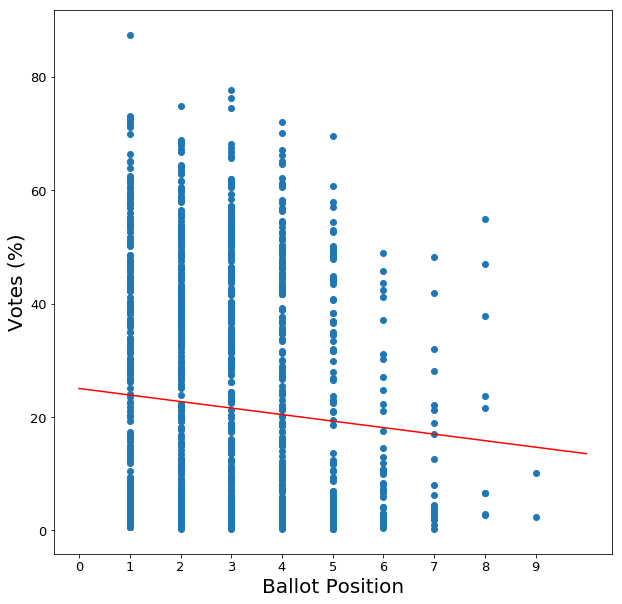

In [59]:
X = data_on_ballot_order.position_ballot
X = sm.add_constant(X)
y = data_on_ballot_order['votes_%']

model = sm.OLS(y, X)

est = model.fit()

const, position_ballot_coef = est.params

plt.scatter(X.position_ballot, y)
plt.xlabel('Ballot Position')
plt.ylabel('Votes (%)')
plt.xticks(np.arange(0, max(X.position_ballot)+1, 1.0))

regresssion_line = map(lambda x: position_ballot_coef * x + const, range(1,12))
plt.plot(regresssion_line, 'r')

est.summary()

## Simulation to demonstrate relation between ballot length and percentage of votes

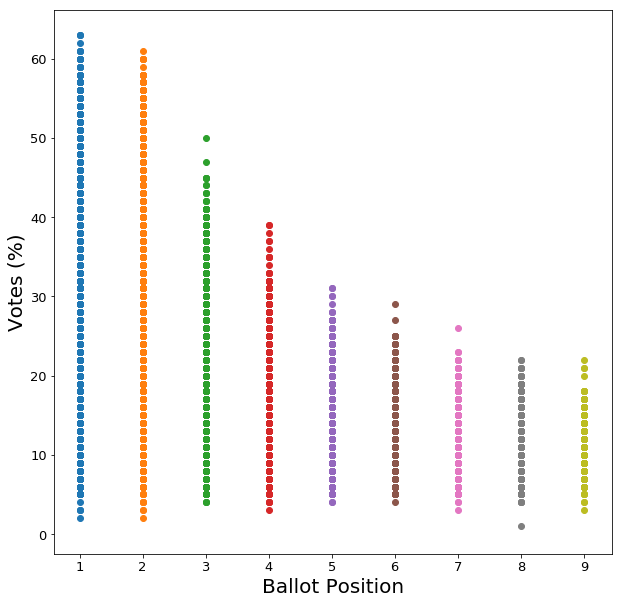

In [57]:
import random

ballot_lengths = map(int, list(data_on_ballot_order.ballot_length.unique()))

all_elections_results = []

for ballot_length in ballot_lengths:
    
    # Simulate elections 100 times for each ballot length
    for _ in range(0,300):
        
        election_results = {}
        for position in range(1, ballot_length + 1):
            election_results[position] = 0
        
        # 100 votes
        for _ in range(0,100):
            position_vote = random.choice(range(1, ballot_length + 1))
            election_results[position_vote] += 1
            
        all_elections_results.append(election_results)
        

df_simulation_results = pd.DataFrame(all_elections_results)

for ballot_position in df_simulation_results.columns:
    plt.scatter([ballot_position] * len(df_simulation_results[ballot_position]), df_simulation_results[ballot_position])
plt.xlabel('Ballot Position')
plt.ylabel('Votes (%)')

## Consider ballot length

In [63]:
X = data_on_ballot_order[['position_ballot', 'ballot_length']]
X = sm.add_constant(X)
y = data_on_ballot_order['votes_%']

model = sm.OLS(y, X)

est = model.fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                votes_%   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     61.97
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           1.94e-26
Time:                        10:26:01   Log-Likelihood:                -5778.7
No. Observations:                1311   AIC:                         1.156e+04
Df Residuals:                    1308   BIC:                         1.158e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              43.0937      1.962     21.967      0.000      39.245      46.942
position_ballot     0.7178      0.394      1.824      0.068      -0.054       1.490
ballot_length      -4.7020      0.442    -10.644      0.000      -5.569      -3.835
==============================================================================
Omnibus:                      291.844   Durbin-Watson:                   2.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.026
Skew:                           0.454   Prob(JB):                     8.53e-22
Kurtosis:                       2.025   Cond. No.                         21.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
# No outliers
print len(y)
print len(scipy.stats.mstats.winsorize(y))

1311
1311
